In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx3m\\" # this
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\test_oscillations\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\conduit1D\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import numerics.differentiation.eval_divu as eval_divu

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [3]:

solver1D_from = lambda i: readwritedatafiles.read_data_file(
  f"conduitSteadyState_inlet_cont_{i}.pkl")
solver2D_from = lambda i: readwritedatafiles.read_data_file(
  f"atm2SteadyState_inlet_cont_{i}.pkl")

solver = solver1D_from(16)


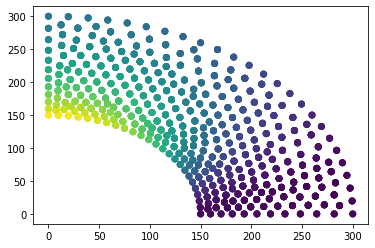

In [4]:
''' Plot test '''
solver = solver2D_from(16)

x_elem_nodes = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=solver.state_coeffs[...,0])

## Polynomial tests for div u computation

In [5]:
''' Construct test values '''

# Ones in all states (zero-divergence)
U_ones = np.ones_like(solver.state_coeffs)

# Linear velocity v ~ y (constant divergence)
U_linear = U_ones.copy()
# Set single phase (partial densities (1, 0, 0))
U_linear[...,1:3] = 0.0
# Set linear vertical velocity field (1, y)
U_linear[...,3:4] = 1.0
U_linear[...,4:5] = x_elem_nodes[...,1:2]

# Linear velocity v ~ y (constant divergence)
U_quad = U_ones.copy()
# Set single phase (partial densities (1, 0, 0))
U_quad[...,1:3] = 0.0
# Set quadratic velocity field (x^2 / 2, y)
U_quad[...,3:4] = 0.5 * x_elem_nodes[...,0:1]**2
U_quad[...,4:5] = x_elem_nodes[...,1:2]

In [6]:
''' Replace pointwise evaluation with projection for test problems with order > 1.'''

# Get quadrature coordinates
order = 2*np.amax([solver.order, 1])
order = solver.physics.get_quadrature_order(np.amax([solver.order, 1]))
quad_order = solver.basis.get_quadrature_order(solver.mesh, order)
quad_pts, quad_wts = solver.basis.get_quadrature_data(quad_order)
eval_pts = quad_pts
nq = eval_pts.shape[0]
# Compute state
xphys = np.empty((solver.mesh.num_elems,) + eval_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  xphys[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, eval_pts)

# Construct collection of evaluated states for overintegration
U_overinteg = np.zeros((U_quad.shape[0], xphys.shape[1], U_quad.shape[2]))
U_overinteg[...,0:1] = 1.0
U_overinteg[...,1:2] = 0.0
U_overinteg[...,2:3] = 0.0
U_overinteg[...,3:4] = 0.5 * xphys[...,0:1] ** 2
U_overinteg[...,4:5] = xphys[...,1:2]
U_overinteg[...,5:6] = 1.0

U_quad_proj = np.zeros_like(U_quad)
solver_tools.L2_projection(solver.mesh,
                           solver.elem_helpers.iMM_elems,
                           solver.basis,
                           solver.elem_helpers.quad_pts,
                           solver.elem_helpers.quad_wts,
                           U_overinteg,
                           U_quad_proj)

# Get quadrature points for plotting
x_elem_quad = solver.elem_helpers.x_elems

Velocity field test case (1, y)


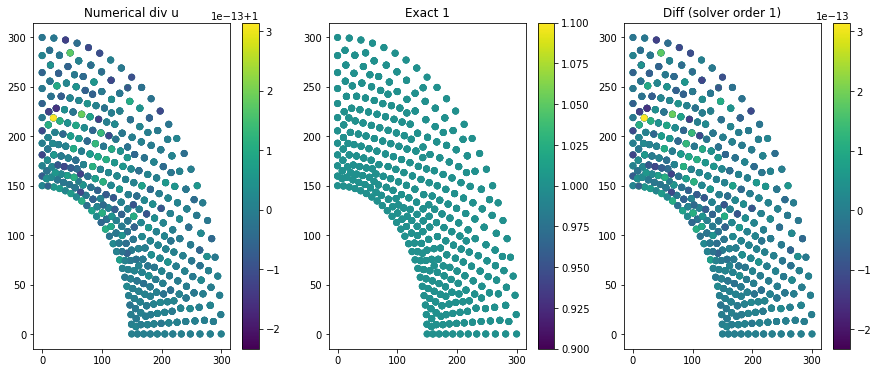

In [7]:
''' Linear test case '''

divu, divu_quad = eval_divu.eval_divu(solver, eval_divu.velocity, U_linear)
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(divu.ravel()))
plt.colorbar()
plt.title("Numerical div u")
plt.subplot(1,3,2)
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(np.ones_like(divu.ravel())))
plt.colorbar()
plt.title("Exact 1")
plt.subplot(1,3,3)
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(divu.ravel() - 1))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order})")
print("Velocity field test case (1, y)")

Velocity field test case (x^2 / 2, y)


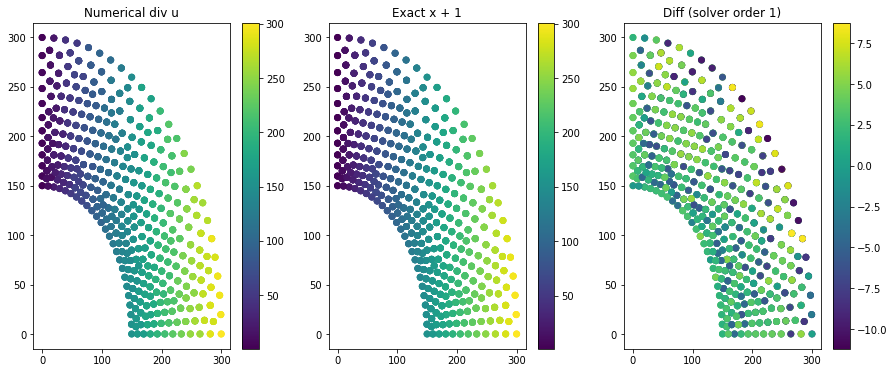

In [8]:
''' Quadratic test case '''

# divu = numerics.differentiation.eval_divu.eval_divu(solver, U_quad)
divu, divu_quad = eval_divu.eval_divu(solver, eval_divu.velocity, U_quad_proj)
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(divu.ravel()))
plt.colorbar()
plt.title("Numerical div u")
plt.subplot(1,3,2)
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(1 + x_elem_nodes[...,0].ravel()))
plt.colorbar()
plt.title("Exact x + 1")
plt.subplot(1,3,3)
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(divu.ravel() - 1 - x_elem_nodes[...,0].ravel()))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order})")
print("Velocity field test case (x^2 / 2, y)")

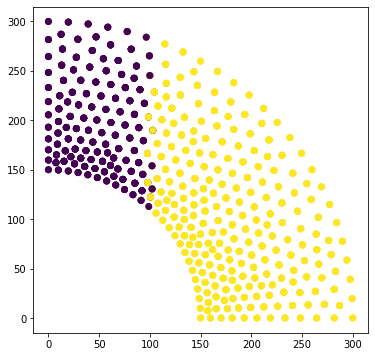

In [9]:
# Check div u threshold
plt.figure(figsize=(6,6))
plt.scatter(x_elem_nodes[...,0].ravel(),
            x_elem_nodes[...,1].ravel(),
            c=(divu.ravel() > 100))

In [10]:
# Comparison to intraelement
def divu_intraelement(elem_helpers, U:np.array, ndims:int=2):
  # Evaluate intraelement gradient at quadrature points
  gUq = np.einsum('ijml, imk -> ijkl', elem_helpers.basis_phys_grad_elems, U)
  # Evaluate state at quadrature points
  Uq = np.einsum('jn, ink -> ijk', elem_helpers.basis_val, U)
  # Compute mixture density
  rho = Uq[:,:,0:3].sum(axis=-1, keepdims=True)
  if ndims == 1:
    u = Uq[:,:,3:4] / rho
    # Chain rule
    grad_u = (gUq[:,:,0:3,:].sum(axis=2) * (-u)
       + gUq[:,:,3,:].sum(axis=2)) / rho
    # Squeeze singleton axis for dimension
    div_u = grad_u[:,:,0]
  elif ndims == 2:
    u = Uq[:,:,3:4] / rho
    v = Uq[:,:,4:5] / rho
    # Gradient of velocity vector [ne, nq, nd:(x,y), nd:(u,v)]
    grad_u = np.stack((
      (gUq[:,:,0:3,:].sum(axis=2) * (-u) + gUq[:,:,3,:]) / rho,
      (gUq[:,:,0:3,:].sum(axis=2) * (-v) + gUq[:,:,4,:]) / rho,), axis=-1)
    # Trace of grad_u for divergence
    div_u = grad_u[:,:,0,0] + grad_u[:,:,1,1]
  else:
    raise NotImplementedError("ndims > 2 not implemented.")
  return np.expand_dims(div_u, axis=-1)



Velocity field test case (x^2 / 2, y)


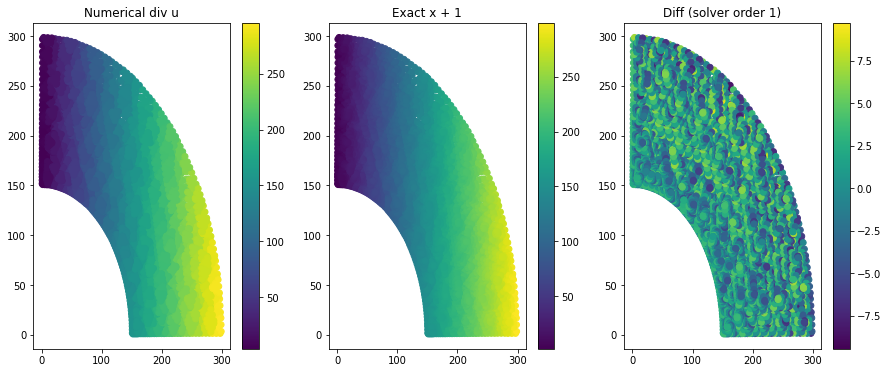

In [11]:
''' Intraelement gradient on quadratic test case '''

# Compute intraelement gradient at quadrature point but apply stride 3
divu_intra = divu_intraelement(solver.elem_helpers,
                               U_quad_proj,
                               2)
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_intra.ravel()))
plt.colorbar()
plt.title("Numerical div u")
plt.subplot(1,3,2)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(1 + x_elem_quad[...,0].ravel()))
plt.colorbar()
plt.title("Exact x + 1")
plt.subplot(1,3,3)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_intra.ravel() - 1 - x_elem_quad[...,0].ravel()))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order})")
print("Velocity field test case (x^2 / 2, y)")

## Sinusoidal test for div u computation
Using a velocity field that is sinusoidal in one direction, we test the weak divergence computation strategy and compare it to the intraelement divergence approximation. The results should be similar for numerical representations with small jumps, but we expect the weak derivative to better approximate the exact divergence.

In [12]:
''' Replace pointwise evaluation with projection for test problems with order > 1.'''

# Get quadrature coordinates
order = 2*np.amax([solver.order, 1])
order = solver.physics.get_quadrature_order(np.amax([solver.order, 1]))
quad_order = solver.basis.get_quadrature_order(solver.mesh, order)
quad_pts, quad_wts = solver.basis.get_quadrature_data(quad_order)
eval_pts = quad_pts
nq = eval_pts.shape[0]
# Compute state
xphys = np.empty((solver.mesh.num_elems,) + eval_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  xphys[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, eval_pts)

# Construct collection of evaluated states for overintegration
U_sin_quad = np.zeros((U_quad.shape[0], xphys.shape[1], U_quad.shape[2]))
U_sin_quad[...,0:1] = 1.0
U_sin_quad[...,1:2] = 0.0
U_sin_quad[...,2:3] = 0.0
# Set outward cosine velocity field
r = np.linalg.norm(xphys, axis=-1, keepdims=True)
n = xphys / r
wavelength = 50.0
amplitude = 1.0
k = 2 * np.pi / wavelength
U_sin_quad[...,3:5] = n * amplitude * np.sin(k * r)
U_sin_quad[...,5:6] = 1.0

U_sin_proj = np.zeros_like(U_quad)
solver_tools.L2_projection(solver.mesh,
                           solver.elem_helpers.iMM_elems,
                           solver.basis,
                           solver.elem_helpers.quad_pts,
                           solver.elem_helpers.quad_wts,
                           U_sin_quad,
                           U_sin_proj)

Text(0.5, 1.0, 'Diff (solver order 1); L2 7.92e+00')

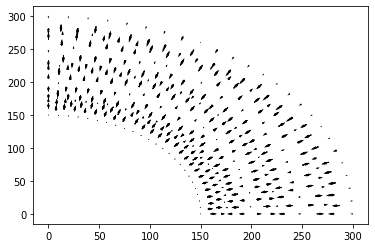

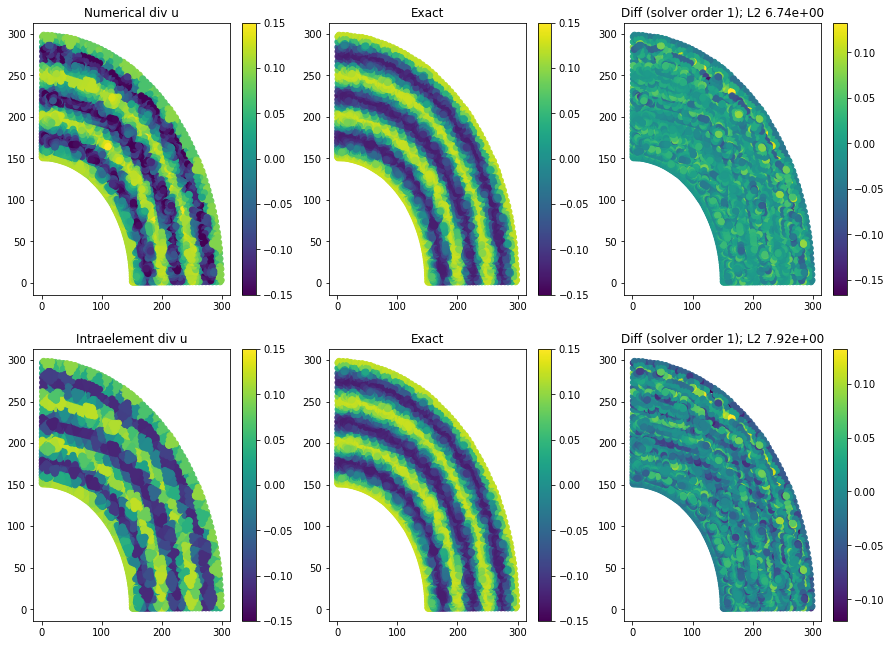

In [13]:
''' sin(r) test case '''

divu, divu_quad = eval_divu.eval_divu(solver, eval_divu.velocity, U_sin_proj)
divu_intra = divu_intraelement(solver.elem_helpers,
                               U_sin_proj,
                               ndims=2)
divsinr_exact = (amplitude * (np.sin(k*r) / r + k * np.cos(k*r)))

# Evaluate L2 error
err_quad = np.sqrt(np.einsum("ijd, jd, ijd -> ",
                             (divu_quad - divsinr_exact)**2, 
                             solver.elem_helpers.quad_wts,
                             solver.elem_helpers.djac_elems))
err_intra = np.sqrt(np.einsum("ijd, jd, ijd -> ",
                              (divu_intra - divsinr_exact)**2, 
                              solver.elem_helpers.quad_wts,
                              solver.elem_helpers.djac_elems))
# Get quadrature point locations for plotting
x_elem_quad = solver.elem_helpers.x_elems

# Show velocity field at nodes
plt.figure()
plt.quiver(x_elem_nodes[...,0].ravel(),
           x_elem_nodes[...,1].ravel(),
           U_sin_proj[...,3:4].ravel(),
           U_sin_proj[...,4:5].ravel())

plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_quad.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Numerical div u")
plt.subplot(2,3,2)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divsinr_exact.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Exact")
plt.subplot(2,3,3)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=((divu_quad - divsinr_exact).ravel()))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order}); L2 {err_quad:.2e}")
plt.subplot(2,3,4)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_intra.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Intraelement div u")
plt.subplot(2,3,5)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divsinr_exact.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Exact")
plt.subplot(2,3,6)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=((divu_intra - divsinr_exact).ravel()))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order}); L2 {err_intra:.2e}")

In [14]:
''' Replace pointwise evaluation with projection for test problems with order > 1.'''

# Get quadrature coordinates
order = 2*np.amax([solver.order, 1])
order = solver.physics.get_quadrature_order(np.amax([solver.order, 1]))
quad_order = solver.basis.get_quadrature_order(solver.mesh, order)
quad_pts, quad_wts = solver.basis.get_quadrature_data(quad_order)
eval_pts = quad_pts
nq = eval_pts.shape[0]
# Compute state
xphys = np.empty((solver.mesh.num_elems,) + eval_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  xphys[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, eval_pts)

# Construct collection of evaluated states for overintegration
U_sin_quad = np.zeros((U_quad.shape[0], xphys.shape[1], U_quad.shape[2]))
U_sin_quad[...,0:1] = 1.0
U_sin_quad[...,1:2] = 0.0
U_sin_quad[...,2:3] = 0.0
# Set outward cosine velocity field
r = np.linalg.norm(xphys, axis=-1, keepdims=True)
n = xphys / r
wavelength = 200 # 20.0
amplitude = 1.0
k = 2 * np.pi / wavelength
U_sin_quad[...,3:5] = n * amplitude * np.sin(k * r)
U_sin_quad[...,5:6] = 1.0

U_sin_proj = np.zeros_like(U_quad)
solver_tools.L2_projection(solver.mesh,
                           solver.elem_helpers.iMM_elems,
                           solver.basis,
                           solver.elem_helpers.quad_pts,
                           solver.elem_helpers.quad_wts,
                           U_sin_quad,
                           U_sin_proj)

Text(0.5, 1.0, 'Diff (solver order 1); L2 5.17e-01')

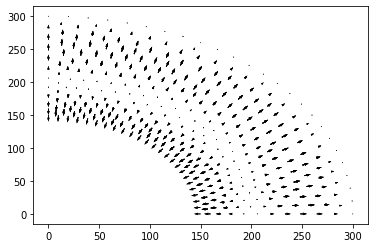

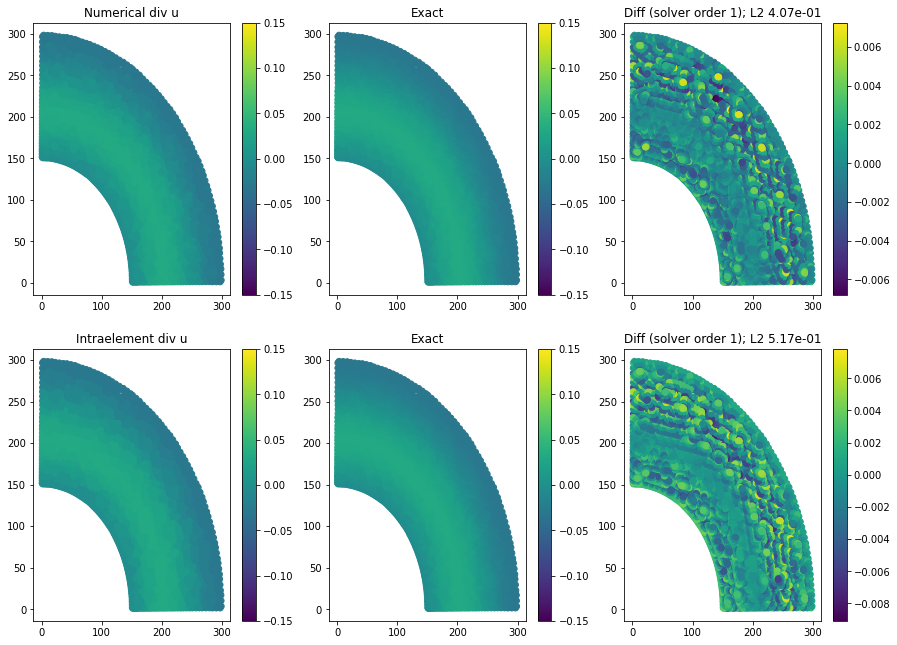

In [15]:
''' sin(r) test case '''

divu, divu_quad = eval_divu.eval_divu(solver, eval_divu.velocity, U_sin_proj)
divu_intra = divu_intraelement(solver.elem_helpers,
                               U_sin_proj,
                               ndims=2)
divsinr_exact = (amplitude * (np.sin(k*r) / r + k * np.cos(k*r)))

# Evaluate L2 error
err_quad = np.sqrt(np.einsum("ijd, jd, ijd -> ",
                             (divu_quad - divsinr_exact)**2, 
                             solver.elem_helpers.quad_wts,
                             solver.elem_helpers.djac_elems))
err_intra = np.sqrt(np.einsum("ijd, jd, ijd -> ",
                              (divu_intra - divsinr_exact)**2, 
                              solver.elem_helpers.quad_wts,
                              solver.elem_helpers.djac_elems))
# Get quadrature point locations for plotting
x_elem_quad = solver.elem_helpers.x_elems

# Show velocity field at nodes
plt.figure()
plt.quiver(x_elem_nodes[...,0].ravel(),
           x_elem_nodes[...,1].ravel(),
           U_sin_proj[...,3:4].ravel(),
           U_sin_proj[...,4:5].ravel())

plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_quad.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Numerical div u")
plt.subplot(2,3,2)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divsinr_exact.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Exact")
plt.subplot(2,3,3)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=((divu_quad - divsinr_exact).ravel()))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order}); L2 {err_quad:.2e}")
plt.subplot(2,3,4)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_intra.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Intraelement div u")
plt.subplot(2,3,5)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divsinr_exact.ravel()))
plt.clim(-.15, .15)
plt.colorbar()
plt.title("Exact")
plt.subplot(2,3,6)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=((divu_intra - divsinr_exact).ravel()))
plt.colorbar()
plt.title(f"Diff (solver order {solver.order}); L2 {err_intra:.2e}")

## Material derivative of state and strain rate

In [16]:
import physics.multiphasevpT.atomics as atomics

U = U_sin_proj.copy()
T = atomics.temperature(U[...,0:3], U[...,3:5], U[...,5:6], solver.physics)
phi = atomics.gas_volfrac(U[...,0:3], T, solver.physics)
p = atomics.pressure(U[...,0:3], T, phi, solver.physics)

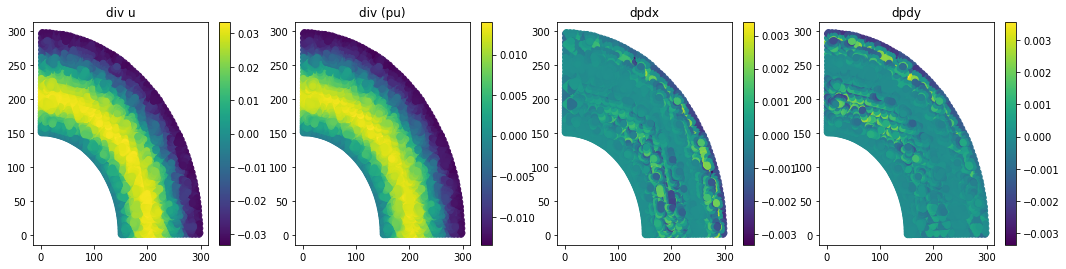

In [17]:
''' sin(r) test case for p, u divergences'''

U_sin_proj_isobaric = U_sin_proj.copy()
U_sin_proj_isobaric[...,5:6] = 1.0 + 0.5 \
  * (U_sin_proj_isobaric[...,3:5]**2).sum(axis=-1, keepdims=True) \
  / U_sin_proj_isobaric[...,0:3].sum(axis=-1, keepdims=True)

divu, divu_quad = eval_divu.eval_divu(solver, eval_divu.velocity, U_sin_proj_isobaric)
divpu, divpu_quad = eval_divu.eval_divu(solver, eval_divu.work_flux, U_sin_proj_isobaric)
dpdx, dpdx_quad = eval_divu.eval_divu(solver, eval_divu.pressure_x_vector, U_sin_proj_isobaric)
dpdy, dpdy_quad = eval_divu.eval_divu(solver, eval_divu.pressure_y_vector, U_sin_proj_isobaric)

# Get quadrature point locations for plotting
x_elem_quad = solver.elem_helpers.x_elems

# # Show velocity field at nodes
# plt.figure()
# plt.quiver(x_elem_nodes[...,0].ravel(),
#            x_elem_nodes[...,1].ravel(),
#            U_sin_proj[...,3:4].ravel(),
#            U_sin_proj[...,4:5].ravel())

plt.figure(figsize=(18,9))
plt.subplot(2,4,1)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divu_quad.ravel()))
plt.title("div u")
plt.colorbar()

plt.subplot(2,4,2)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(divpu_quad.ravel()))
plt.title("div (pu)")
plt.colorbar()

plt.subplot(2,4,3)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(dpdx_quad.ravel()))
plt.title("dpdx")
plt.colorbar()

plt.subplot(2,4,4)
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(dpdy_quad.ravel()))
plt.title("dpdy")
plt.colorbar()


In [18]:
# Version hacking
solver.physics.state_slices["pDensityFm"] = slice(7, 8, None)
solver.physics.state_indices["pDensityFm"] = 7

In [19]:
''' Test strain rate computation '''

# Get representation at quadrature points
U = U_sin_quad

# Compute source contribution
# is_version_mismatched:bool = False
# if is_version_mismatched:
#   S = np.zeros_like(U_sin_proj_isobaric)
# else:
source_sum = np.stack([source.get_source(solver.physics,
                                      U_sin_quad,
                                      x_elem_quad,
                                      solver.time)
                       for source in solver.physics.source_terms],axis=-1).sum(axis=-1)

# Assemble non-advective terms for material derivative computation
non_advective_terms = np.zeros(U_sin_quad.shape)
non_advective_terms[...,3:4] = dpdx_quad
non_advective_terms[...,4:5] = dpdy_quad
non_advective_terms[...,5:6] = divpu_quad
# Compute material derivative at quadrature points
DUDt = source_sum - U * divu_quad - non_advective_terms
# Compute pressure state-gradient
p_sgrad = solver.physics.compute_pressure_sgradient(U_sin_quad)
# Compute material derivative of pressure through chain rule
DpDt = np.einsum("ijk, ijk -> ij", p_sgrad, DUDt)[:,:,np.newaxis]
# Compute proportional volumetric dilation
rho0, K = solver.physics.Liquid["rho0"], solver.physics.Liquid["K"]
rho = U[...,0:3].sum(axis=-1, keepdims=True)
strain_rate = (-rho0 * rho0 / K) * DpDt / (rho*rho)

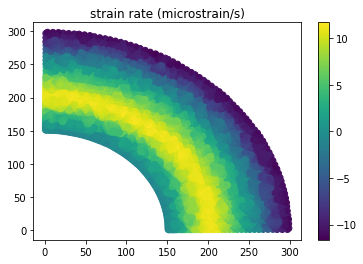

In [20]:
''' Plot strain rates '''
plt.scatter(x_elem_quad[...,0].ravel(),
            x_elem_quad[...,1].ravel(),
            c=(strain_rate.ravel() * 1e6))
plt.title("strain rate (microstrain/s)")
plt.colorbar()